<div align="center">

### Lab 4

# National Tsing Hua University

#### Spring 2024

#### 11220IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 4: Predicting Stock Price with Deep Learning

</div>

### Introduction

In this lab, we explore the application of time-series datasets using Long Short-Term Memory (LSTM) networks, a type of recurrent neural network, to predict stock prices. Specifically, we will use historical price data from Nvidia to forecast the stock's price for the next day based on the prices of the previous N days. This approach is particularly relevant given the volatile nature of stock markets and the increasing reliance on automated trading systems.

### Objectives

- To understand the fundamentals of LSTM networks and their application in time-series forecasting.
- To develop a predictive model that can accurately forecast Nvidia's stock price for the next day using historical data.

### Dataset

The dataset for this lab is from the "Huge Stock Market Dataset" available on Kaggle. This dataset includes daily prices and volumes for all US stocks and ETFs, with a specific focus on Nvidia (NVDA). The dataset features include:

- **Date**: The recorded data points.
- **Open**: The price at which the stock first traded upon the opening of an exchange on a given trading day.
- **High**: The highest price at which the stock traded during the trading day.
- **Low**: The lowest price at which the stock traded during the trading day.
- **Close**: The price of the stock at closing time.
- **Volume**: The number of shares or contracts traded in a security or an entire market during a given period.
- **OpenInt**: The total number of outstanding derivative contracts, like options or futures. [More details here](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/discussion/121096)

### References

- [Huge Stock Market Dataset](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs) for the dataset used in this lab.


## A. Checking and Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [117]:

import pandas as pd

#df = pd.read_csv('nvda.us.txt')
df = pd.read_csv('/content/drive/MyDrive/lab4/nvda.us.txt')
df

,Date,Open,High,Low,Close,Volume,OpenInt
0,1999-01-22,1.6238,1.8092,1.4379,1.5215,18297633,0
1,1999-01-25,1.6423,1.6980,1.5215,1.6793,3445279,0
2,1999-01-26,1.6980,1.7350,1.5311,1.5494,2320993,0
3,1999-01-27,1.5586,1.5957,1.4660,1.5494,1662658,0
4,1999-01-28,1.5494,1.5586,1.5311,1.5401,1540110,0
...,...,...,...,...,...,...,...
4728,2017-11-06,207.2000,209.9800,206.7000,209.6300,9731783,0
4729,2017-11-07,210.5500,212.9000,210.0560,212.0000,10671815,0
4730,2017-11-08,211.8500,212.0000,207.2400,209.1600,13033902,0
4731,2017-11-09,205.2700,206.3300,200.3700,205.3200,23895006,0


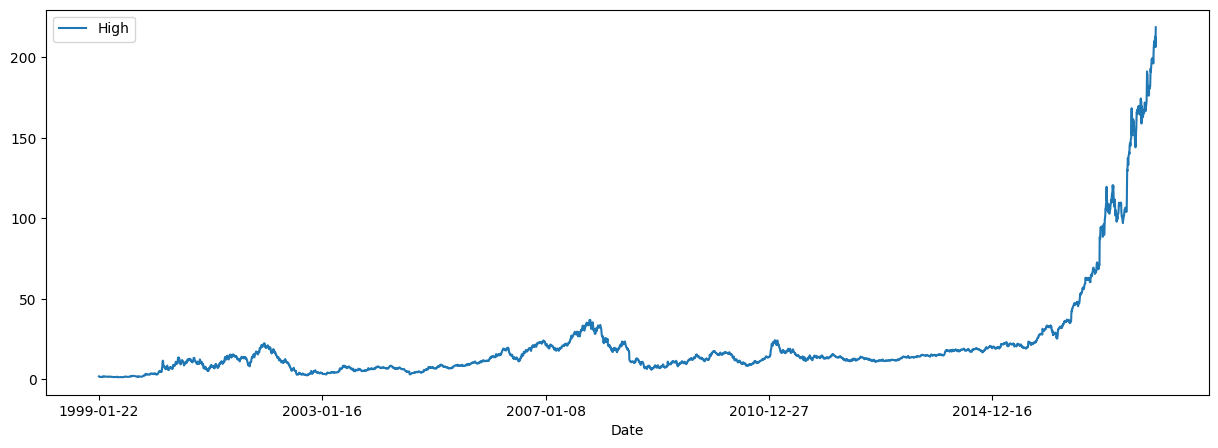

In [118]:
plot = df.plot('Date', 'High', figsize=(15, 5))

In [119]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4733 entries, 0 to 4732
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     4733 non-null   object 
 1   Open     4733 non-null   float64
 2   High     4733 non-null   float64
 3   Low      4733 non-null   float64
 4   Close    4733 non-null   float64
 5   Volume   4733 non-null   int64  
 6   OpenInt  4733 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 259.0+ KB


In [121]:
# checking for null values
df.isnull().sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

In [122]:
df = df.dropna()

In [123]:
df.shape

(4733, 7)

In [124]:
df.describe()

,Open,High,Low,Close,Volume,OpenInt
count,4733.000000,4733.000000,4733.000000,4733.000000,4.733000e+03,4733.0
mean,20.796242,21.157332,20.420417,20.805404,1.615287e+07,0.0
std,30.236284,30.615622,29.792958,30.263705,1.272446e+07,0.0
min,1.298900,1.317500,1.233900,1.261900,0.000000e+00,0.0
25%,7.988300,8.247900,7.756400,7.978900,8.181100e+06,0.0
50%,12.963000,13.238000,12.721000,12.990000,1.390271e+07,0.0
75%,19.141000,19.418000,18.778000,19.106000,2.051602e+07,0.0
max,213.080000,218.670000,211.630000,216.140000,2.496659e+08,0.0


In [125]:
#Normalize
from sklearn.preprocessing import StandardScaler
num = ['Open', 'High', 'Low', 'Close', 'Volume']
MS = StandardScaler()

df[num] = MS.fit_transform(df[num])

#### Converting the DataFrame to a NumPy Array

In [126]:
# windows是指要把幾天包在一起，step是指包好之後 要跳多少天，再包下一筆(和convolution的step size概念一樣)
# 拿連續n天4種的股價 去預測n+1天的最高股價
def create_sequences(input_data, output_data, window_size, step):
    sequences = []
    labels = []
    for i in range(0, len(input_data) - window_size, step):
        sequences.append(input_data[i:(i + window_size)])
        labels.append(output_data[i + window_size])
    return np.array(sequences), np.array(labels)

In [127]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Select features
#features = df[['High']]
features = df[['Open', 'High', 'Low', 'Close']] #作業有一題要加入'Volume' # 作業有一題要思考input features，因為要預測high，那需要四種都拿還是拿high就好?
#features = df[['Open', 'High', 'Low', 'Close', 'Volume']] #作業有一題要加入'Volume' # 作業有一題要思考input features，因為要預測high，那需要四種都拿還是拿high就好?
labels = df['High'].shift(-1)  # Next day's high price as label

# 建立序列
window_size = 10 #10
step = 5 #15
X, y = create_sequences(features, labels, window_size=window_size, step=step) # 作業第一題 指從第一天開始抓10個還10天 預測第11天的股價。包好10天之後會跳15天(從第15天開始包 中間有留空隙)
# 如果step size是1，第一包是第1到10天，第2包是第2到12天...

print(f'Shape of data X: {X.shape}')
print(f'Shape of data y: {y.shape}')

# split the hold-out tests
ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int) # 10% hold-out # 意思是每10% 就包成一個task
x_test = X[ind]
y_test = y[ind]
all_ind = np.arange(len(X))
remains_ind = np.delete(all_ind, ind)

X = X[remains_ind]
y = y[remains_ind]

# shuffle dataset
ind = np.random.permutation(len(X))
X = X[ind]
y = y[ind]
split_point = int(X.shape[0]*0.8)

# shape的意思 315、10、4。 315是最後包出315份，每一份有10天，每一天有4種features。
# label是315個是因為每10天會預測1個，所以315包總共預測315個

x_train = X[:split_point] #227是315乘以0.8
y_train = y[:split_point] #52是315乘以0.2
x_val = X[split_point:]
y_val = y[split_point:]
# train有227份、val有52份、test有31份

print(f'Shape of data x_train: {x_train.shape}')
print(f'Shape of data y_train: {y_train.shape}')
print(f'Shape of data x_val: {x_val.shape}')
print(f'Shape of data y_val: {y_val.shape}')
print(f'Shape of data x_test: {x_test.shape}')
print(f'Shape of data y_test: {y_test.shape}')

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

batch_size = 32

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in training and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')

Shape of data X: (945, 10, 4)
Shape of data y: (945,)
Shape of data x_train: (680, 10, 4)
Shape of data y_train: (680,)
Shape of data x_val: (171, 10, 4)
Shape of data y_val: (171,)
Shape of data x_test: (94, 10, 4)
Shape of data y_test: (94,)
Number of samples in training and validation are 680 and 171.


## B. Defining Neural Networks

In [128]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True) # 定義 LSTM 層
        self.fc = nn.Linear(hidden_dim, output_dim) # 定義全連接層

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]) # 只取 LSTM 輸出的最後一個時間點的輸出
        return out

## C. Training the Neural Network

In [95]:
# Check your GPU status.
!nvidia-smi

Wed May  1 15:39:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0              32W /  70W |    321MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [129]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []

epochs = 100

# 初始化模型並將其移至 GPU
model = LSTMModel(input_dim=4, hidden_dim=500, num_layers=2, output_dim=1).cuda() # 作業第二題第一小題 因為調整輸入維度 這裡input_dim4要改成5
print(model)

best_val_loss = float('inf')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0

    for features, labels in train_loader:
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features).squeeze(-1)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Learning rate update
    lr_scheduler.step()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for features, labels in val_loader:
            features = features.cuda()
            labels = labels.cuda()
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpoint
    # 儲存表現較好的模型
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}, Best Val loss: {best_val_loss:.4f}')

    # Store performance
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

LSTMModel(
  (lstm): LSTM(4, 500, num_layers=2, batch_first=True)
  (fc): Linear(in_features=500, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 0.1722, Val loss: 0.0266, Best Val loss: 0.0266
Epoch 2/100, Train loss: 0.0192, Val loss: 0.0412, Best Val loss: 0.0266
Epoch 3/100, Train loss: 0.0210, Val loss: 0.0084, Best Val loss: 0.0084
Epoch 4/100, Train loss: 0.0108, Val loss: 0.0724, Best Val loss: 0.0084
Epoch 5/100, Train loss: 0.0178, Val loss: 0.0153, Best Val loss: 0.0084
Epoch 6/100, Train loss: 0.0083, Val loss: 0.0094, Best Val loss: 0.0084
Epoch 7/100, Train loss: 0.0060, Val loss: 0.0073, Best Val loss: 0.0073
Epoch 8/100, Train loss: 0.0069, Val loss: 0.0029, Best Val loss: 0.0029
Epoch 9/100, Train loss: 0.0059, Val loss: 0.0180, Best Val loss: 0.0029
Epoch 10/100, Train loss: 0.0054, Val loss: 0.0020, Best Val loss: 0.0020
Epoch 11/100, Train loss: 0.0058, Val loss: 0.0069, Best Val loss: 0.0020
Epoch 12/100, Train loss: 0.0075, Val loss: 0.0194, Best Val loss: 0.0020
Epoch 13/100, Train loss: 0.0045, Val loss: 0.0177, Best Val loss: 0.0020
Epoch 14/100, Train loss: 0.0039, Val loss: 0.0

#### Visualizing the model performance

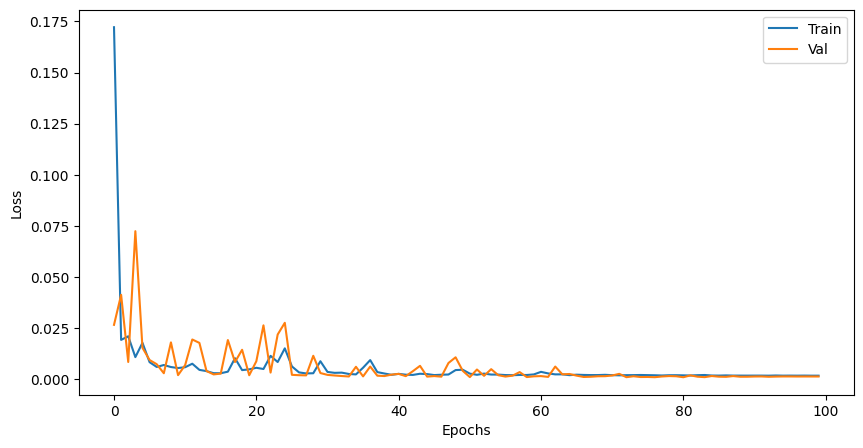

In [130]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

In [131]:
# Load the trained weights
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

pred_value = []
actual_value = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.cuda()
        outputs = model(features).squeeze(-1)
        pred_value.append(outputs.cpu())
        actual_value.append(labels)

pred_value = torch.cat(pred_value)
actual_value = torch.cat(actual_value)

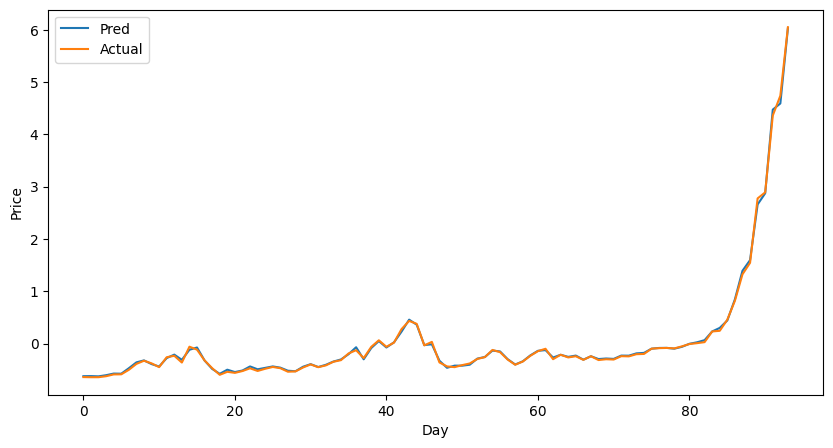

In [132]:
plt.figure(figsize=(10, 5))
plt.plot(pred_value[:])
plt.plot(actual_value[:])
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['Pred', 'Actual'])

plt.show()

In [115]:
print(train_losses)
print(val_losses)
print(best_val_loss)

[1006.5273395885121, 805.726787220348, 889.7158973000267, 891.983846837824, 930.1548957824707, 772.2915052934127, 866.0944734053178, 797.4975148981267, 771.1920845725319, 732.0727258162065, 708.58950770985, 628.7095554091713, 525.5412784706463, 445.4305382804437, 386.79012680324644, 327.487669324333, 281.89557461982423, 250.3981413380666, 221.52751755443487, 200.2463258965449, 183.01682634245265, 183.63905599171466, 144.0345539491285, 131.40412444418126, 117.85497110269286, 108.49893728711389, 99.58811049976133, 118.37484722787684, 86.72778530012478, 79.88708122887395, 74.09027281132612, 69.1707128801129, 64.88807559690692, 62.70703572779894, 56.958122690292925, 54.39798796854236, 50.35695637220686, 46.02236692607403, 43.648323861035436, 45.35846026106314, 38.37726466357708, 35.267540418288924, 33.65511145374992, 34.2552325210788, 28.892349329861727, 26.86419283666394, 25.685708623040806, 28.48545663465153, 40.78561728109013, 21.699219444935974, 21.07462628050284, 23.041360367428172, 2

In [133]:
# 把各組超參數的數據整理進一個 Python 字典，然後轉換為 pandas DataFrame，以便於展示和分析
import pandas as pd
import os

# 假設以下變量已經包含了在給定的超參數設定下從訓練過程中收集的數據
# train_losses, train_accuracies, val_losses, val_accuracies


# 最後一個 Epoch 的訓練和驗證損失
final_train_losses = train_losses[-1]
final_val_losses = val_losses[-1]
final_best_val_loss = best_val_loss

# 將所有數據組織成一個字典
result = {
    'window_size': [window_size],
    'step': [step],
    'Train loss': [final_train_losses],
    'Val loss': [final_val_losses],
    'Best Val loss': [final_best_val_loss]
}

# # 轉換字典為 pandas DataFrame
# results_df = pd.DataFrame(result)

# 轉換字典為 DataFrame 的一行
new_results_df = pd.DataFrame(result)

# CSV 文件的路徑
results_csv_file = '/content/drive/MyDrive/lab4/results.csv'

# 檢查文件是否存在
if os.path.exists(results_csv_file):
    # 如果文件存在，載入現有的 DataFrame 並追加新數據
    existing_df = pd.read_csv(results_csv_file)
    updated_df = pd.concat([existing_df, new_results_df], ignore_index=True)
    print("Existing DataFrame type:", type(existing_df))
else:
    # 如果文件不存在，則創建一個新的 DataFrame
    updated_df = new_results_df

print("New DataFrame type:", type(new_results_df))

# 將更新後的 DataFrame 儲存到 CSV 文件中
updated_df.to_csv(results_csv_file, index=False)

# 顯示更新後的 DataFrame
print(updated_df)


Existing DataFrame type: <class 'pandas.core.frame.DataFrame'>
New DataFrame type: <class 'pandas.core.frame.DataFrame'>
    window_size  step   Train loss     Val loss  Best Val loss  \
0            10    15    92.791000   227.271000     227.271000   
1            10     5     5.371000    11.998000      11.995000   
2            20     5     6.753000    12.188000      12.153000   
3            20    30   460.759000     0.287000       0.280000   
4            15    10    45.145000    52.625000      52.625000   
5             5    10    45.558000    54.117000      54.117000   
6            10     5     7.373000     5.375000       5.322000   
7            10     5   911.313000  1507.868000    1497.500000   
8            10     5    11.578486    19.172588      19.149096   
9            10     5     5.811608     3.107458       2.818739   
10           10     5    10.541937     7.324514       6.519104   
11           10     5     7.964621    16.980320      16.954209   
12           10     5